In [21]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [22]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f2 = pd.read_csv('../input/f2_train.csv', index_col='TransactionID')
# del train_f2['isFraud']
# test_f2 = pd.read_csv('../input/f2_test.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 54.4 s, sys: 3.86 s, total: 58.3 s
Wall time: 58.1 s


In [23]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)

In [24]:
train_test = train_transaction.append(test_transaction)
# count编码
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())

# C5很强，用于编码
for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    train_transaction[col+'_C5count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
    test_transaction[col+'_C5count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [25]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    col_count = train_test.groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(-1).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(-1).map(col_count)

In [26]:
# 部分V特征是非整数，几乎无意义，有些模型去掉它
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113
0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V7

In [27]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f2, how='left', left_index=True, right_index=True)
# test = test.merge(test_f2, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
# del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

# del train, test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        if f in ['card1','card2','id_01']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

(590540, 516)
(506691, 515)


In [28]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = True
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]

Memory usage of dataframe is 2344.82 MB
Memory usage after optimization is: 713.84 MB
Decreased by 69.6%
Memory usage of dataframe is 2014.72 MB
Memory usage after optimization is: 623.06 MB
Decreased by 69.1%
CPU times: user 3min 13s, sys: 8min 26s, total: 11min 39s
Wall time: 11min 38s


In [29]:
%%time

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds+= clf.predict_proba(X_test)[:,1] / folds
#     X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] / folds))   

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  

# X_train_pred['pred'] = y_oof
# X_train_pred['isFraud'] = y_train
# X_train_pred['card1'] = X_train['card1']
# X_train_pred['card2'] = X_train['card2']
# X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
# X_train_pred.to_csv('simple_xgboost_cv2.csv')
# X_test_pred['card1'] = X_test['card1']
# X_test_pred['card2'] = X_test['card2']
# X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
# X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9661782611986149
debug: 0.9263564646412201
ROC AUC 0.9664873088495958
debug: 0.9272125435182221
ROC AUC 0.9680967956774408
debug: 0.9249260589813795
debug: 0.9311505374220808
CPU times: user 2min 10s, sys: 1min 11s, total: 3min 22s
Wall time: 3min 36s


In [30]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
514 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.9941968  0.02554537]
513 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.9943703  0.02554537]
512 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.9943703  0.02554537]
511 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.9943703  0.02554537]
510 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.9943703  0.02554537]
509 id_35_count 149464.0 149464.0 149464.0 149464.0 [0.9943703  0.02554537]
508 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.9943633  0.02554537]
507 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.99410015 0.02554537]
506 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.9941738  0.02554537]
505 id_31_count 926.0 23650.0 926.0 23655.0 [0.99390477 0.02554537]
504 id_30_count 42170.0 711.0 42170.0 711.0 [0.9948913  0.02554537]
503 id_29_count 149264.0 149264.0 149264.0 149264.0 [0.9948913  0.02

386 V334 0.0 0.0 0.0 0.0 [0.99678314 0.02554537]
385 V333 0.0 0.0 0.0 0.0 [0.99678314 0.02554537]
384 V332 0.0 20.0 0.0 20.0 [0.99675995 0.02554537]
383 V331 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
382 V330 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
381 V329 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
380 V328 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
379 V327 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
378 V326 0.0 1.0 0.0 1.0 [0.99667114 0.02554537]
377 V325 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
376 V324 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
375 V323 0.0 1.0 0.0 1.0 [0.99667114 0.02554537]
374 V322 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
373 V321 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
372 V320 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
371 V319 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
370 V318 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
369 V317 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
368 V316 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
367 V315 0.0 20.0 0.0 20.0 [0.99667114 0.02554537]
366 V314 0.0 20.

218 V166 475.0 0.0 475.0 0.0 [0.98738956 0.02554537]
217 V165 250.0 0.0 250.0 0.0 [0.98738956 0.02554537]
216 V164 250.0 0.0 250.0 0.0 [0.9880229  0.02554537]
215 V163 0.0 0.0 0.0 0.0 [0.9880229  0.02554537]
214 V162 0.0 0.0 0.0 0.0 [0.9880229  0.02554537]
213 V161 0.0 0.0 0.0 0.0 [0.9880229  0.02554537]
212 V160 0.0 40.0 0.0 40.0 [0.98744386 0.02554537]
211 V159 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
210 V158 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
209 V157 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
208 V156 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
207 V155 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
206 V154 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
205 V153 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
204 V152 4.0 1.0 4.0 1.0 [0.98658425 0.02554537]
203 V151 4.0 1.0 4.0 1.0 [0.98658425 0.02554537]
202 V150 4.0 1.0 4.0 1.0 [0.98658425 0.02554537]
201 V149 0.0 0.0 0.0 0.0 [0.98658425 0.02554537]
200 V148 0.0 0.0 0.0 0.0 [0.98658425 0.02554537]
199 V147 0.0 0.0 0.0 0.0 [0.98658425 0.02554537]
198 V1

46 M3 2 2 nan nan [0.98434514 0.02554537]
45 M2 2 2 nan nan [0.98434514 0.02554537]
44 M1 2 2 nan nan [0.98434514 0.02554537]
43 D15 nan 280.0 nan 280.0 [0.9744586  0.02554537]
42 D14 386.0 nan 386.0 nan [0.97459644 0.02554537]
41 D13 nan nan nan nan [0.97459644 0.02554537]
40 D12 nan nan nan nan [0.97459644 0.02554537]
39 D11 nan nan nan nan [0.97459644 0.02554537]
38 D10 nan nan nan nan [0.97459644 0.02554537]
37 D9 0.04166 0.04166 0.04166600108146668 0.04166600108146668 [0.97459644 0.02554537]
36 D8 1.042 17.05 1.041666030883789 17.04166603088379 [0.9740181  0.02554537]
35 D7 nan 16.0 nan 16.0 [0.97431254 0.02554537]
34 D6 nan 55.0 nan 55.0 [0.9620047  0.02554537]
33 D5 nan nan nan nan [0.9620047  0.02554537]
32 D4 nan nan nan nan [0.9620047  0.02554537]
31 D3 nan nan nan nan [0.9620047  0.02554537]
30 D2 nan 17.0 nan 17.0 [0.9639276  0.02554537]
29 D1 0.0 17.0 0.0 17.0 [0.9603081  0.02554537]
28 C14 0.0 9.0 0.0 9.0 [0.56919414 0.02554537]
27 C13 0.0 24.0 0.0 24.0 [0.11139716 0.0255

In [31]:
features = [x for x in X_train.columns if x not in col_del]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=800,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :], X_train[features].iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds11+= clf.predict_proba(X_test[features])[:,1] / folds
    if debug:    
        print("debug:",roc_auc_score(y_test, clf.predict_proba(X_test[features])[:,1] / folds))   

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5))

ROC AUC 0.9682320193119953
debug: 0.9269095982552805
ROC AUC 0.9683337819005914
debug: 0.926749073891428
ROC AUC 0.9697132868313301
debug: 0.9250692674097744
debug: 0.9321216538332904
debug: 0.9323063531892098


In [32]:
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


Weight,Feature
0.1143,V258
0.0265,V70
0.0215,V244
0.0199,V189
0.0199,V91
0.0185,V257
0.0151,C1_count
0.0113,C4
0.0109,V294
0.0106,C14


In [33]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
cate = [x for x in X_train.columns if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") ]
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 3,
          'data_random_seed': 17}

early_stop = 500
verbose_eval = 30
num_rounds = 600
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test, label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds2+= model.predict(X_test) / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.945086	valid_1's auc: 0.894763
[60]	valid_0's auc: 0.96125	valid_1's auc: 0.907188
[90]	valid_0's auc: 0.966096	valid_1's auc: 0.910462
[120]	valid_0's auc: 0.968021	valid_1's auc: 0.911526
[150]	valid_0's auc: 0.969417	valid_1's auc: 0.911823
[180]	valid_0's auc: 0.970167	valid_1's auc: 0.912345
[210]	valid_0's auc: 0.970805	valid_1's auc: 0.912648
[240]	valid_0's auc: 0.971171	valid_1's auc: 0.912744
[270]	valid_0's auc: 0.971498	valid_1's auc: 0.912901
[300]	valid_0's auc: 0.971696	valid_1's auc: 0.912713
[330]	valid_0's auc: 0.971756	valid_1's auc: 0.912885
[360]	valid_0's auc: 0.971814	valid_1's auc: 0.91298
[390]	valid_0's auc: 0.971952	valid_1's auc: 0.913333
[420]	valid_0's auc: 0.971954	valid_1's auc: 0.913474
[450]	valid_0's auc: 0.971854	valid_1's auc: 0.913372
[480]	valid_0's auc: 0.971828	valid_1's auc: 0.913295
[510]	valid_0's auc: 0.971735	valid_1's auc: 0.913105
[540]	valid_0's auc: 0.971631	valid_1's auc: 0.913231
[570]	valid_0's auc: 0.97153	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.943969	valid_1's auc: 0.896569
[60]	valid_0's auc: 0.960704	valid_1's auc: 0.910084
[90]	valid_0's auc: 0.965727	valid_1's auc: 0.914465
[120]	valid_0's auc: 0.967918	valid_1's auc: 0.916246
[150]	valid_0's auc: 0.968902	valid_1's auc: 0.917009
[180]	valid_0's auc: 0.969686	valid_1's auc: 0.917384
[210]	valid_0's auc: 0.97036	valid_1's auc: 0.917926
[240]	valid_0's auc: 0.970714	valid_1's auc: 0.918646
[270]	valid_0's auc: 0.970956	valid_1's auc: 0.918367
[300]	valid_0's auc: 0.971248	valid_1's auc: 0.918308
[330]	valid_0's auc: 0.971451	valid_1's auc: 0.918677
[360]	valid_0's auc: 0.971587	valid_1's auc: 0.919049
[390]	valid_0's auc: 0.971694	valid_1's auc: 0.919534
[420]	valid_0's auc: 0.971865	valid_1's auc: 0.91937
[450]	valid_0's auc: 0.971967	valid_1's auc: 0.919205
[480]	valid_0's auc: 0.971964	valid_1's auc: 0.918821
[510]	valid_0's auc: 0.971984	valid_1's auc: 0.918584
[540]	valid_0's auc: 0.972099	valid_1's auc: 0.918508
[570]	valid_0's auc: 0.972153	val

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.949533	valid_1's auc: 0.898773
[60]	valid_0's auc: 0.963543	valid_1's auc: 0.908707
[90]	valid_0's auc: 0.968342	valid_1's auc: 0.913351
[120]	valid_0's auc: 0.970164	valid_1's auc: 0.915139
[150]	valid_0's auc: 0.971236	valid_1's auc: 0.915541
[180]	valid_0's auc: 0.971942	valid_1's auc: 0.915412
[210]	valid_0's auc: 0.9724	valid_1's auc: 0.91535
[240]	valid_0's auc: 0.972899	valid_1's auc: 0.91566
[270]	valid_0's auc: 0.973204	valid_1's auc: 0.91598
[300]	valid_0's auc: 0.97329	valid_1's auc: 0.916275
[330]	valid_0's auc: 0.973341	valid_1's auc: 0.916299
[360]	valid_0's auc: 0.97357	valid_1's auc: 0.916097
[390]	valid_0's auc: 0.973691	valid_1's auc: 0.916241
[420]	valid_0's auc: 0.973665	valid_1's auc: 0.916361
[450]	valid_0's auc: 0.973666	valid_1's auc: 0.916356
[480]	valid_0's auc: 0.973738	valid_1's auc: 0.916204
[510]	valid_0's auc: 0.97373	valid_1's auc: 0.916476
[540]	valid_0's auc: 0.97378	valid_1's auc: 0.916358
[570]	valid_0's auc: 0.973748	valid_1's 

In [34]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5)) 

debug: 0.9311505374220808
debug: 0.9247145911807212
debug: 0.9373606375195153


Index(['TransactionDT', 'card1', 'TransactionAmt', 'card1_count', 'hour',
       'addr1', 'D15', 'weekday', 'addr1_count', 'id_02', 'dist1', 'D4',
       'card1_C5count', 'card2', 'card2_count', 'addr1_C5count',
       'addr1_amtcount', 'card1_amtcount', 'D10', 'card2_C5count', 'D2', 'C13',
       'D8', 'id_20', 'id_31_count', 'card2_amtcount', 'id_20_count', 'id_19',
       'id_19_count', 'D11', 'C13_count', 'D5', 'D1', 'D3', 'C1', 'C14_count',
       'DeviceInfo_count', 'id_31', 'P_emaildomain', 'dist2', 'M4_count', 'C2',
       'DeviceInfo', 'C1_count', 'V307', 'card5_count', 'C6_count', 'M5_count',
       'id_06', 'C14', 'C11', 'D9', 'M6_count', 'C6', 'card5_C5count', 'D14',
       'id_13', 'card5_amtcount', 'C2_count', 'id_13_count', 'V313',
       'id_06_count', 'id_05', 'id_05_count', 'V310', 'M4', 'C11_count', 'M6',
       'C9_count', 'id_01', 'id_01_count', 'C9', 'V127', 'V45', 'D6',
       'id_30_count', 'D12', 'V75', 'V308', 'V87', 'id_33_count', 'V315',
       'V314', 'V53'

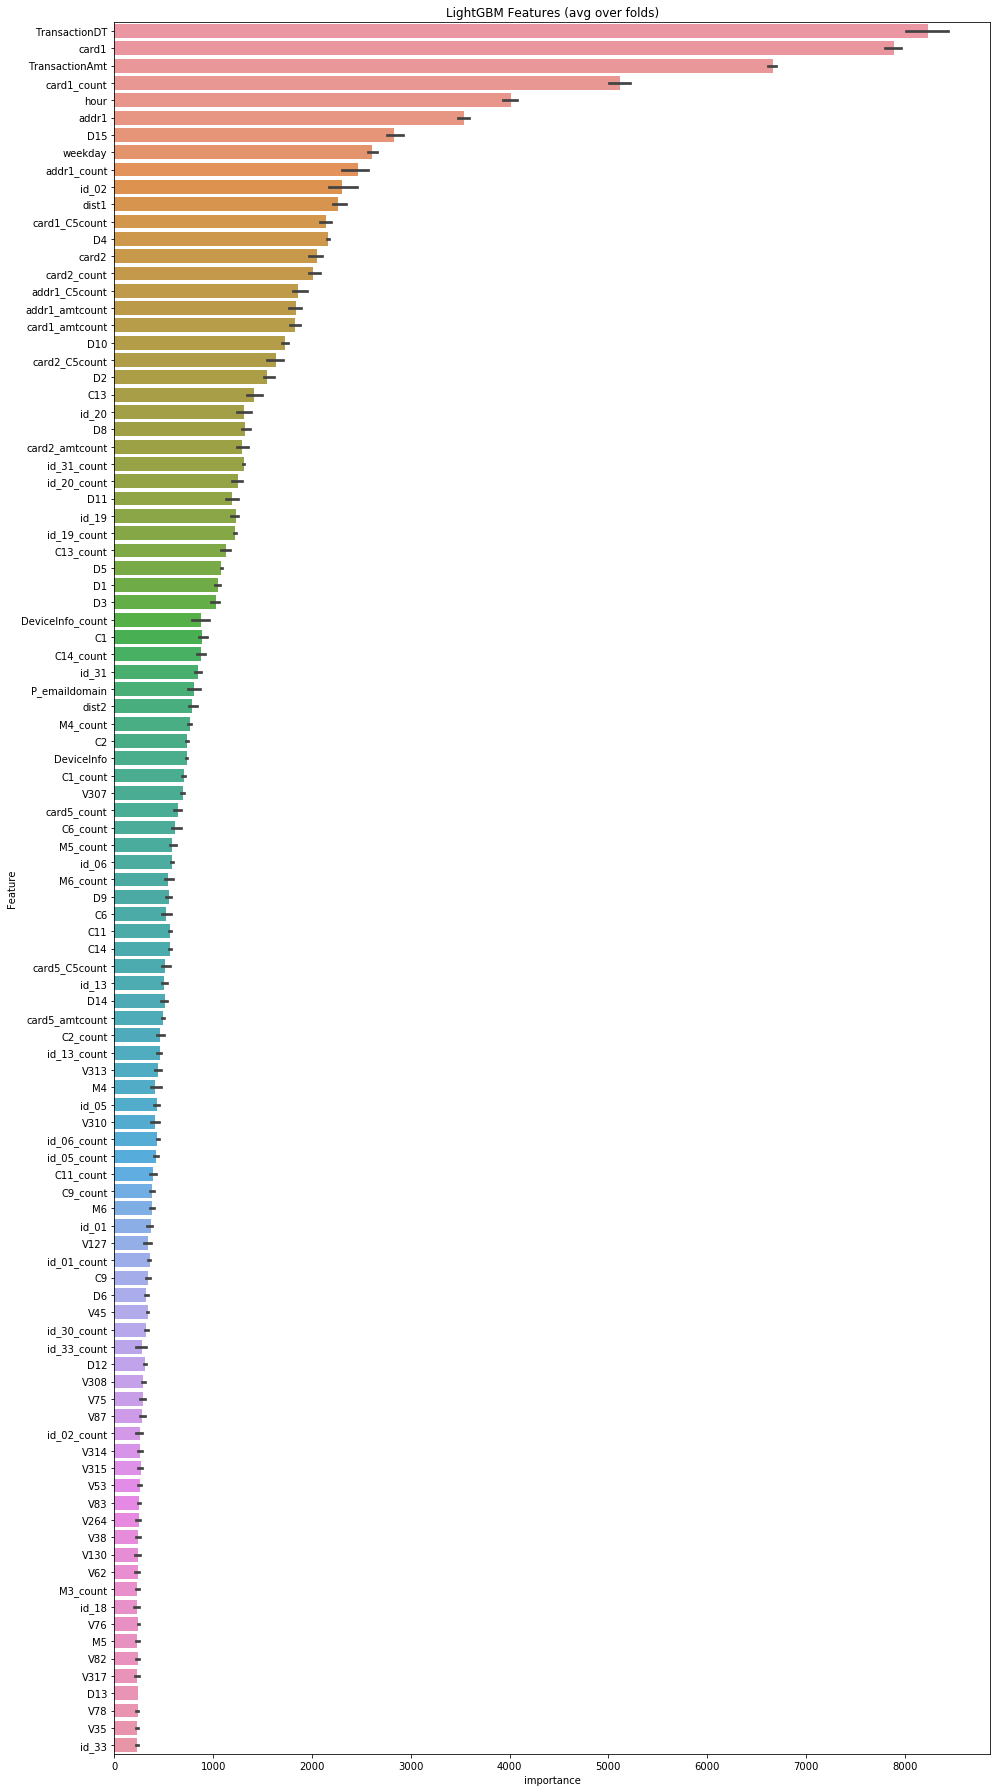

In [35]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [36]:
import catboost as cb
from catboost import CatBoostClassifier,Pool


features = [x for x in X_train.columns]

cate = [x for x in X_train.columns if (x == 'ProductCD' or x in ['card1','card2'] or x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" ]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 800

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train[features].iloc[tr_idx, :].fillna(-1), X_train[features].iloc[val_idx, :].fillna(-1)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=14,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,task_type = "GPU",devices = ["3"])
    if debug:
        model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test[features].fillna(-1), y_test),verbose_eval = 30)
    else:
        model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl[features], y_vl),verbose_eval = 30)
        
    y_pred_train = model.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds3+= model.predict_proba(X_test[features].fillna(-1))[:,1] / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict_proba(X_test[features].fillna(-1))[:,1] / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33))

['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6152130	test: 0.6158441	best: 0.6158441 (0)	total: 756ms	remaining: 10m 4s
30:	learn: 0.0906998	test: 0.1068727	best: 0.1068727 (30)	total: 21.4s	remaining: 8m 50s
60:	learn: 0.0660185	test: 0.0901918	best: 0.0901918 (60)	total: 42.5s	remaining: 8m 35s
90:	learn: 0.0565442	test: 0.0865706	best: 0.0865706 (90)	total: 1m 4s	remaining: 8m 18s
120:	learn: 0.0518907	test: 0.0852057	best: 0.0852057 (120)	total: 1m 25s	remaining: 7m 57s
150:	learn: 0.0491280	test: 0.0843662	best: 0.0843662 (150)	total: 1m 46s	remaining: 7m 35s
180:	learn: 0.0470422	test: 0.0839474	best: 0.0839474 (180)	total: 2m 6s	remaining: 7m 14s
210:	learn: 0.0455025	test: 0.0835888	best: 0.0835888 (210)	total: 2m 27s	remaining: 6m 51s
240:	learn: 0.0437496	test: 0.0832101	best: 0.0832101 (240)	total: 2m 48s	remaining: 6m 30s
270:	learn: 0.0422871	test: 0.0829973	best: 0.0829919 (266)	total: 3m 9s	re

In [37]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33))

debug: 0.9311505374220808
debug: 0.9247145911807212
debug: 0.9208217173120362
debug: 0.9354568339695938
debug: 0.9390082070823886
debug: 0.9391136216557666


In [38]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33))
    

debug: 0.9311505374220808
debug: 0.9247145911807212
debug: 0.9208217173120362
debug: 0.9354568339695938
debug: 0.9390082070823886
debug: 0.9391136216557666


In [39]:

sample_submission['isFraud'] = (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33
sample_submission.to_csv('simple_ensemble6.csv')


ValueError: Length of values does not match length of index